In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [ ]:
results_path = Path("../../../results/classifiers")
STEP = "error_detection"

In [3]:
models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "nomic-ai/modernbert-embed-base",
    "Alibaba-NLP/gte-modernbert-base",
    "ibm-granite/granite-embedding-english-r2",
    "google/embeddinggemma-300m",
    "Qwen/Qwen3-Embedding-0.6B",
]
models_names = [mn.replace('/', '--') for mn in models]

strategies = [
    "mention_text",
    "concat_prefix",
    "concat_suffix",
    "span_embedding",
]

In [4]:
from transformers import AutoConfig
model_types = {m: AutoConfig.from_pretrained(m).model_type for m in models}
model_types_df = pd.DataFrame.from_dict(model_types, orient='index', columns=['model_type']).reset_index(level=0, names=['model_name'])
model_types_df

,model_name,model_type
0,sentence-transformers/all-MiniLM-L6-v2,bert
1,sentence-transformers/all-mpnet-base-v2,mpnet
2,nomic-ai/modernbert-embed-base,modernbert
3,Alibaba-NLP/gte-modernbert-base,modernbert
4,ibm-granite/granite-embedding-english-r2,modernbert
5,google/embeddinggemma-300m,gemma3_text
6,Qwen/Qwen3-Embedding-0.6B,qwen3


In [5]:
from sentence_transformers import SentenceTransformer

model_sizes = {
    m: sum(p.numel() for p in SentenceTransformer(m, device='cpu').parameters())
    for m in models
}
model_sizes_df = pd.DataFrame.from_dict(model_sizes, orient='index', columns=['num_parameters']).reset_index(level=0, names=['model_name'])
model_sizes_df['model_size'] = model_sizes_df['num_parameters'].apply(lambda x: f"{x/1e6:.1f}M")
model_sizes_df.sort_values('num_parameters', inplace=True)
model_sizes_df

README.md: 0.00B [00:00, ?B/s]

You are trying to use a model that was created with Sentence Transformers version 5.1.0, but you're currently using version 4.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


,model_name,num_parameters,model_size
0,sentence-transformers/all-MiniLM-L6-v2,22713216,22.7M
1,sentence-transformers/all-mpnet-base-v2,109486464,109.5M
2,nomic-ai/modernbert-embed-base,149014272,149.0M
3,Alibaba-NLP/gte-modernbert-base,149014272,149.0M
4,ibm-granite/granite-embedding-english-r2,149014272,149.0M
5,google/embeddinggemma-300m,307581696,307.6M
6,Qwen/Qwen3-Embedding-0.6B,595776512,595.8M


- the five smallest models are based on encoder-only architectures:
    - with 22.7M parameters, the smallest model (`sentence-transformers/all-MiniLM-L6-v2`) is a little less then one fifth the size of the next larger model (`sentence-transformers/all-mpnet-base-v2` with 109.5M parameters)
    - the next bigger models are all based on `modernbert-base` and therefore have 149M parameters (`nomic-ai/modernbert-embed-base`, `Alibaba-NLP/gte-modernbert-base`, `ibm-granite/granite-embedding-english-r2`)
- the two larger models are both based on (decoder-only) LLMs and therefore two respectively four times as large as the bigger encoder-only embedding models:
    - `google/embeddinggemma-300m` with 307.6M parameters
    - and `Qwen/Qwen3-Embedding-0.6B` with 595.8M parameters

In [6]:
# get color palette for strategies
strategy_palette = sns.color_palette("husl", len(strategies))
# create a custom legend below the plots with correct colors
strategy_legend_labels = strategies
strategy_legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=strategy_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(strategy_legend_labels)
]

## attribute dimension classification

In [7]:
task = "attribute_dimension_classification"
label_classes = ["economic", "noneconomic"]

### Model selection step

In [ ]:
results_dir = results_path / task / STEP / "setfit"

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})

df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

df['model_name'] = pd.Categorical(df['model_name'], categories=models_names, ordered=True)
df['model'] = df['model_name'].str.split('--', expand=True)[1]
df['strategy'] = pd.Categorical(df['strategy'], categories=strategies, ordered=True)

df.sort_values(["method", "model_name", "strategy", "fold"], inplace=True)

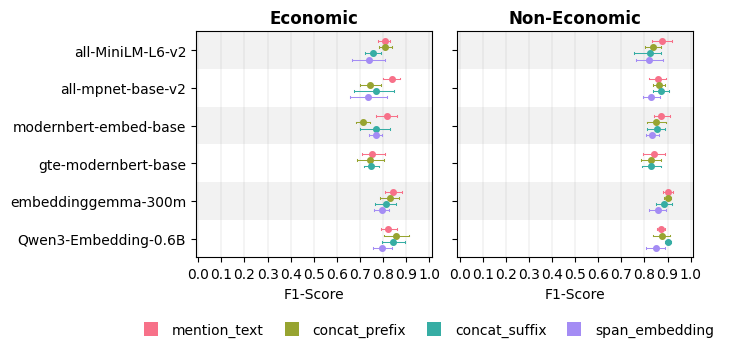

In [9]:
pdat = df.query("what in @label_classes").copy()
pdat['dim'] = pdat['what'].str.replace('non', 'non-')

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True, constrained_layout=True)

for ax, (dim, subdf) in zip(axes, pdat.groupby("dim")):
    # ax.xaxis.set_minor_locator(AutoMinorLocator(1))

    # add grey horizontal stripes at alternating y positions
    for i in range(len(models_names)):
        if i % 2 == 0:
            ax.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

    # add major and minor grid lines
    ls = '-' # (0, (5, 10))
    ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

    sns.pointplot(
        ax=ax,
        data=subdf,
        y="model",
        x="f1-score",
        hue="strategy",
        palette=strategy_palette,
        errorbar='ci',
        # reduce the size of poinst
        markersize=3,
        capsize=.05,
        err_kws={'linewidth': .75},
        # do not connect the points
        linestyle='none',
        dodge=0.5,
        # place legend outside
        legend=False
    )

    # add bold title and labels
    ax.set_title(dim.title(), fontweight='bold')
    ax.set_xlabel("F1-Score")
    ax.set_ylabel("")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# create a custom legend below the plots with correct colors
fig.legend(
    handles=strategy_legend_elements, 
    ncol=len(strategy_legend_labels), 
    loc='lower center', bbox_to_anchor=(0.6, -0.15),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # align center
    bbox_transform=fig.transFigure,
)
fig.show()

In [10]:
model_sizes['Qwen/Qwen3-Embedding-0.6B']/model_sizes['sentence-transformers/all-MiniLM-L6-v2']

26.230389919243493

Insights

- overall, using only the mention text as classifier input works best for attribute dimension classification
    - the only exception is the relatively large Qwen3-Embddding-0.6B model
- with this strategy, `embeddinggemma-300m` consistenly achieves top performance
- yet, while larger models tend to perform overall slightly better it is remarkable 
    - that the head win is often rather small 
    - and even the smallest model achieves competitive results despite having about 26 times _fewer_ parameters than the largerst one
- from this analysis, `embeddinggemma-300m` emerges as the most reliable base model for classifier fine-tuning.

In [11]:
pdat.query("strategy=='mention_text'").groupby(['model_name'],observed=False)['f1-score'].mean().sort_values(ascending=False)

model_name
google--embeddinggemma-300m                  0.870971
sentence-transformers--all-mpnet-base-v2     0.849133
nomic-ai--modernbert-embed-base              0.845164
Qwen--Qwen3-Embedding-0.6B                   0.845039
sentence-transformers--all-MiniLM-L6-v2      0.840710
Alibaba-NLP--gte-modernbert-base             0.798096
ibm-granite--granite-embedding-english-r2         NaN
Name: f1-score, dtype: float64

In [12]:
# regress F1 score on strategy, conditional on model and controlling for dim
# !pip install statsmodels==0.14.5
import statsmodels.api as sm
from statsmodels.formula.api import ols

# model = ols("f1 ~ C(strategy)*C(model) + C(dim)", data=pdat.rename(columns={"f1-score": "f1"})).fit()
model = ols("f1 ~ C(strategy) + C(model) + C(dim)", data=pdat.rename(columns={"f1-score": "f1"})).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     f1   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     17.26
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.84e-21
Time:                        14:26:14   Log-Likelihood:                 347.16
No. Observations:                 230   AIC:                            -674.3
Df Residuals:                     220   BIC:                            -639.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.8374      0.011     74.603      0.000       0.815       0.860
C(strategy)[T.concat_prefix]         -0.0213      0.010     -2.137      0.034      -0.041      -0.002
C(strategy)[T.concat_suffix]         -0.0198      0.010     -1.979      0.049      -0.039   -8.62e-05
C(strategy)[T.span_embedding]        -0.0470      0.011     -4.420      0.000      -0.068      -0.026
C(model)[T.all-MiniLM-L6-v2]         -0.0428      0.012     -3.500      0.001      -0.067      -0.019
C(model)[T.all-mpnet-base-v2]        -0.0374      0.012     -3.059      0.002      -0.062      -0.013
C(model)[T.embeddinggemma-300m]       0.0016      0.012      0.132      0.895      -0.022       0.026
C(model)[T.gte-modernbert-base]      -0.0687      0.013     -5.130      0.000      -0.095      -0.042
C(model)[T.modernbert-embed-base]    -0.0407      0.012     -3.330      0.001      -0.065      -0.017
C(dim)[T.non-economic]                0.0710      0.007      9.839      0.000       0.057       0.085
==============================================================================
Omnibus:                        4.229   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.900
Skew:                          -0.308   Prob(JB):                        0.142
Kurtosis:                       3.168   Cond. No.                         8.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
interaction_plot??

Object `interaction_plot` not found.


In [14]:
smgraphics.interaction_plot?

Object `smgraphics.interaction_plot` not found.


In [15]:
pdat

,method,model_name,strategy,fold,what,precision,recall,f1-score,support,model,dim
0,setfit,sentence-transformers--all-MiniLM-L6-v2,mention_text,fold01,economic,0.736842,0.823529,0.777778,34.0,all-MiniLM-L6-v2,economic
1,setfit,sentence-transformers--all-MiniLM-L6-v2,mention_text,fold01,noneconomic,0.800000,0.818182,0.808989,44.0,all-MiniLM-L6-v2,non-economic
0,setfit,sentence-transformers--all-MiniLM-L6-v2,mention_text,fold02,economic,0.741935,0.793103,0.766667,29.0,all-MiniLM-L6-v2,economic
1,setfit,sentence-transformers--all-MiniLM-L6-v2,mention_text,fold02,noneconomic,0.966667,0.878788,0.920635,66.0,all-MiniLM-L6-v2,non-economic
0,setfit,sentence-transformers--all-MiniLM-L6-v2,mention_text,fold03,economic,0.833333,0.806452,0.819672,31.0,all-MiniLM-L6-v2,economic
...,...,...,...,...,...,...,...,...,...,...,...
1,setfit,Qwen--Qwen3-Embedding-0.6B,span_embedding,fold03,noneconomic,0.878378,0.942029,0.909091,69.0,Qwen3-Embedding-0.6B,non-economic
0,setfit,Qwen--Qwen3-Embedding-0.6B,span_embedding,fold04,economic,0.827586,0.827586,0.827586,29.0,Qwen3-Embedding-0.6B,economic
1,setfit,Qwen--Qwen3-Embedding-0.6B,span_embedding,fold04,noneconomic,0.838235,0.876923,0.857143,65.0,Qwen3-Embedding-0.6B,non-economic
0,setfit,Qwen--Qwen3-Embedding-0.6B,span_embedding,fold05,economic,0.651163,0.848485,0.736842,33.0,Qwen3-Embedding-0.6B,economic


#### Error analysis

**TODOs:**

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

## Granular attributes classification

### Economic attributes

In [135]:
task = "economic_attributes_classification"
label_classes = [
    'economic__class_membership',
    'economic__education_level',
    'economic__occupation_profession',
    'economic__employment_status',
    'economic__income_wealth_economic_status',
    'economic__ecology_of_group',
]

#### Model selection step

In [ ]:
results_dir = results_path / task / STEP / "setfit"

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

In [137]:
df['model'] = df['model_name'].str.split('--', expand=True)[1]

In [138]:
df['model_name'] = pd.Categorical(df['model_name'], categories=models_names, ordered=True)
df['strategy'] = pd.Categorical(df['strategy'], categories=strategies, ordered=True)

In [139]:
df.sort_values(["method", "model_name", "strategy", "fold"], inplace=True)

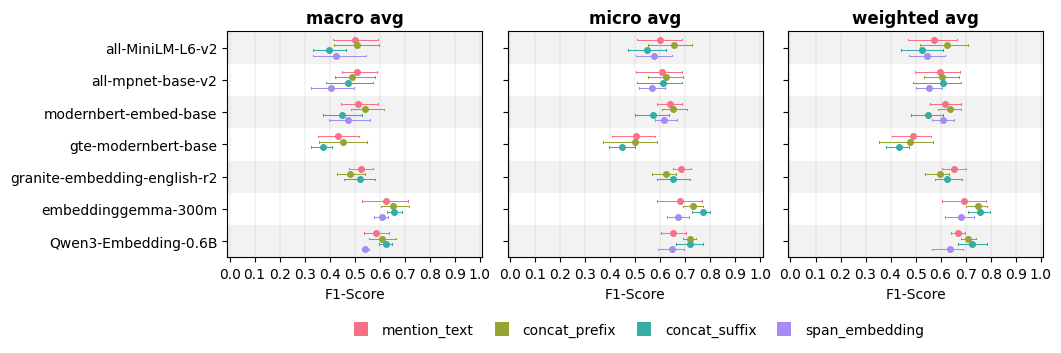

In [140]:
metrics = ["weighted avg", "macro avg", "micro avg"]
pdat = df.query("what in @metrics").copy()

fig, axes = plt.subplots(1, 3, figsize=(7*1.5, 3), sharey=True, constrained_layout=True)

# get color palette for strategies
palette = sns.color_palette("husl", len(strategies))

for ax, (metric, subdf) in zip(axes, pdat.groupby("what")):

    # add grey horizontal stripes at alternating y positions
    for i in range(len(models_names)):
        if i % 2 == 0:
            ax.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

    # add major and minor grid lines
    ls = '-' # (0, (5, 10))
    ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

    sns.pointplot(
        ax=ax,
        data=subdf,
        y="model",
        x="f1-score",

        hue="strategy",
        palette=strategy_palette,
        dodge=0.5,

        linestyle='none',
        markersize=3,

        errorbar='ci',
        capsize=.05,
        err_kws={'linewidth': .75},

        legend=False
    )

    # add bold title and labels
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel("F1-Score")
    ax.set_ylabel("")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# create a custom legend below the plots with correct colors
legend_labels = df['strategy'].unique()
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=strategy_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(legend_labels)
]
fig.legend(
    handles=legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.6, -0.15),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # align center
    bbox_transform=fig.transFigure,
)
fig.show()

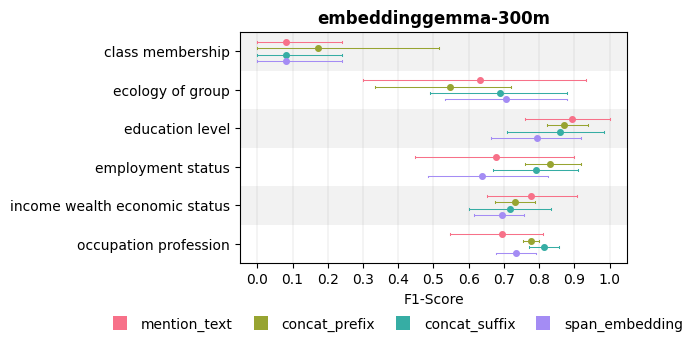

In [141]:
model = "embeddinggemma-300m"
pdat = df.query("model==@model and what in @label_classes").copy()

pdat["attribute"] = pdat["what"].str.replace("economic__", "").str.replace("_", " ")

# clip f1-scores to [0, 1]
pdat.loc[:, "f1-score"] = pdat["f1-score"].clip(0, 1)

plt.figure(figsize=(5, 3))

# add grey horizontal stripes at alternating y positions
for i in range(pdat['attribute'].nunique()):
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

# add major and minor grid lines
ls = '-' # (0, (5, 10))

plt.grid(axis='x', which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="attribute",
    x="f1-score",
    
    markersize=3,
    linestyle='none',
    
    hue="strategy",
    palette=strategy_palette,
    dodge=0.5,
    
    errorbar='ci',
    capsize=.05,
    err_kws={'linewidth': .75},
    
    legend=False
)

# add bold title and labels
plt.title(model, fontweight='bold')
plt.xlabel("F1-Score")
plt.ylabel("")
plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, 0.1))

plt.legend(
    handles=strategy_legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.4, -0.35),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # # align center
    # 
)
plt.show()

In [142]:
pdat_agg = pdat.query("strategy=='concat_prefix'").groupby(["attribute"]).agg(
    f1=("f1-score", "mean"),
    f1_std=("f1-score", "std"),
    support=("support", "mean"),
    support_std=("support", "std"),
).reset_index()

Text(0, 0.5, '$N_{test}$')

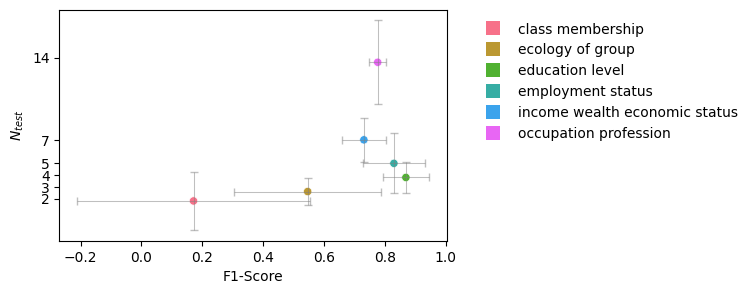

In [143]:
# using `pdat`, create a scatter plot of `f1-score`` against `support`

attributes = pdat_agg['attribute'].unique()
attributes_palette = sns.color_palette("husl", len(attributes))

plt.figure(figsize=(5, 3))


# add vertical error bars for stddev of f1-score
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        xerr=row["f1_std"],
        fmt='none',
        ecolor='gray',
        # palette=attributes_palette,
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )
# add horizontal error bars for stddev of support
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        yerr=row["support_std"],
        fmt='none',
        ecolor='gray',
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )


sns.scatterplot(
    data=pdat_agg,
    y="support",
    x="f1",
    hue="attribute",
    palette=attributes_palette,
    alpha=1,
    # s=100,
    legend=False
)

plt.yticks(pdat_agg.support.round(0))

# create custom legend handles for attributes
attributes = pdat_agg['attribute'].unique()
attributes_legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=attributes_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(attributes)
]
# show legend 
plt.legend(
    handles=attributes_legend_elements,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
)
plt.xlabel("F1-Score")
plt.ylabel("$N_{test}$")

#### Error analysis

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

In [ ]:
# results_dir = results_path / task / STEP / "setfit"

preds_df = pd.concat({
    fp.parts[-5:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['model'] = preds_df['model_name'].str.split('--', expand=True)[1]
preds_df['model_name'] = pd.Categorical(preds_df['model_name'], categories=models_names, ordered=True)
preds_df['strategy'] = pd.Categorical(preds_df['strategy'], categories=strategies, ordered=True)

preds_df = preds_df.sort_values(["method", "model_name", "strategy", "mention_id", "attribute", "fold"]).reset_index(drop=True)

In [145]:
preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [146]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [147]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [148]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for (a, l), subdf in error_rates_df.groupby(['attribute', 'label']):
    # print attribute name in bold
    print(f"\033[1m{a}\033[0m ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
    for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
        highlighted_text = highlight(row['text'], row['mention'])
        print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
    print()

economic__class_membership ~> false positives
  -  93712_199611-377435-1 (0.42):  Within these forms of agricultural exploitation (practiced also in Western Countries), the peasants remain owners of the land with which they have entered into association.
  -  22110_201006-322802-1 (0.38):  From shareholders and managers who merely measure the performance of companies to the short-term profit.

economic__class_membership ~> false negatives
  -  13951_197702-181934-1 (1.00):  The tax system has ended up in an unparalleled bureaucracy, where it is not uncommon for ordinary people to seek accountant assistance to fill out their self-statement.
  -  51320_201706-244572-1 (1.00):  Too many ordinary people know this.
  -   42110_198611-03946-1 (1.00):  Powerful cliques behind and within the old parties are heading towards the Great Coalition.
  -  13229_199803-187861-3 (1.00):  Far from the public light, few people in the business world and in the political systems of both Denmark and the EU 

<Axes: >

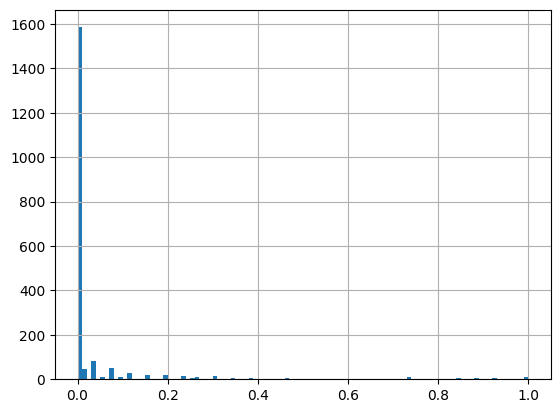

In [149]:
error_rates_df.error.hist(bins=100)

In [150]:
error_rates_df_review_economic = error_rates_df.copy()

error_rate_threshold_economic = np.quantile(error_rates_df.error, 0.95)
print(error_rate_threshold_economic)
error_rates_df_review_economic['label'] = error_rates_df_review_economic['label'].astype(str)
idxs = error_rates_df_review_economic.error > error_rate_threshold_economic
error_rates_df_review_economic.loc[idxs, 'label'] = error_rates_df_review_economic.loc[idxs, 'label'].astype(str) + '??'

0.2692307692307692


In [151]:
# error_rates_df_review_economic = error_rates_df_review_economic.pivot(index=['mention_id', 'text', 'mention', 'span'], columns='attribute', values='label').reset_index()
# error_rates_df_review_economic.columns.name = None

# these = error_rates_df_review_economic.iloc[:, 4:].apply(lambda row: row.apply(lambda v: '??' in v).any(), axis=1)
# error_rates_df_review_economic = error_rates_df_review_economic[these]

# len(error_rates_df_review_economic)

### Non-economic attributes

In [152]:
task = "noneconomic_attributes_classification"
label_classes = [
    'noneconomic__age',
    'noneconomic__crime',
    'noneconomic__ethnicity',
    'noneconomic__family',
    'noneconomic__gender_sexuality',
    'noneconomic__health',
    'noneconomic__nationality',
    'noneconomic__place_location',
    'noneconomic__religion',
    'noneconomic__shared_values_mentalities',
]

#### Model selection step

In [ ]:
results_dir = results_path / task / STEP / "setfit"

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

In [154]:
df['model'] = df['model_name'].str.split('--', expand=True)[1]

In [155]:
df['model_name'] = pd.Categorical(df['model_name'], categories=models_names, ordered=True)
df['strategy'] = pd.Categorical(df['strategy'], categories=strategies, ordered=True)

In [156]:
df.sort_values(["method", "model_name", "strategy", "fold"], inplace=True)

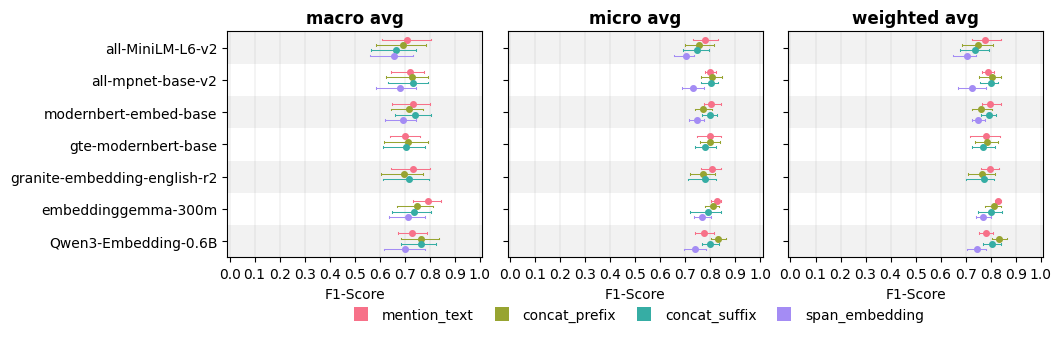

In [157]:
metrics = ["weighted avg", "macro avg", "micro avg"]
pdat = df.query("what in @metrics").copy()

fig, axes = plt.subplots(1, 3, figsize=(7*1.5, 3), sharey=True, constrained_layout=True)

# get color palette for strategies
palette = sns.color_palette("husl", len(strategies))

for ax, (metric, subdf) in zip(axes, pdat.groupby("what")):

    # add grey horizontal stripes at alternating y positions
    for i in range(len(models_names)):
        if i % 2 == 0:
            ax.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

    ls = '-' # (0, (5, 10))
    ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

    sns.pointplot(
        ax=ax,
        data=subdf,
        y="model",
        x="f1-score",
        hue="strategy",
        palette=strategy_palette,
        errorbar='ci',
        # reduce the size of poinst
        markersize=3,
        capsize=.05,
        err_kws={'linewidth': .75},
        # do not connect the points
        linestyle='none',
        dodge=0.5,
        # place legend outside
        legend=False
    )

    # add bold title and labels
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel("F1-Score")
    ax.set_ylabel("")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# create a custom legend below the plots with correct colors
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=strategy_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(strategies)
]
fig.legend(
    handles=legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.6, -0.1),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # align center
    bbox_transform=fig.transFigure,
)
fig.show()

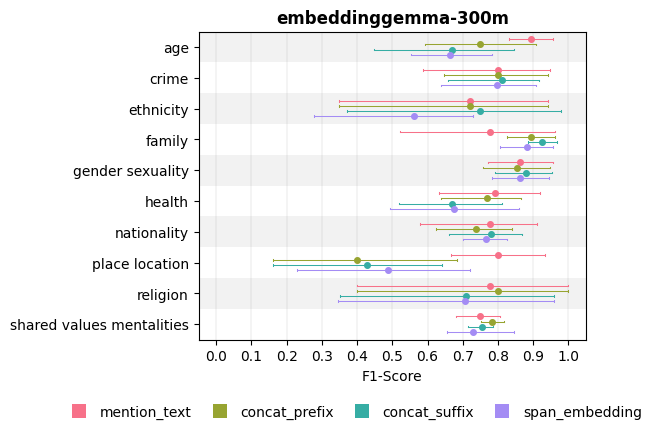

In [158]:
model = "embeddinggemma-300m"
pdat = df.query("model==@model and what in @label_classes").copy()

pdat["attribute"] = pdat["what"].str.replace("noneconomic__", "").str.replace("_", " ")

# clip f1-scores to [0, 1]
pdat.loc[:, "f1-score"] = pdat["f1-score"].clip(0, 1)

plt.figure(figsize=(5, pdat["attribute"].nunique() * 0.4))

# add grey horizontal stripes at alternating y positions
for i in range(pdat['attribute'].nunique()):
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

# add major and minor grid lines
ls = '-' # (0, (5, 10))
plt.grid(axis='x', which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="attribute",
    x="f1-score",
    hue="strategy",
    palette=strategy_palette,
    errorbar='ci',
    # reduce the size of poinst
    markersize=3,
    capsize=.05,
    err_kws={'linewidth': .75},
    # do not connect the points
    linestyle='none',
    dodge=0.5,
    # place legend outside
    legend=False
)

# add bold title and labels
plt.title(model, fontweight='bold')
plt.xlabel("F1-Score")
plt.ylabel("")
plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, 0.1))

plt.legend(
    handles=strategy_legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.4, -0.3),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # # align center
    # 
)
plt.show()


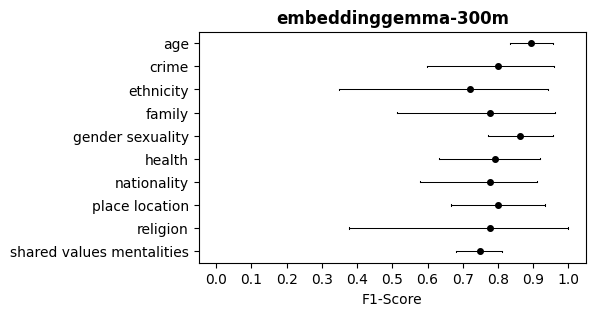

In [159]:
pdat = pdat.query("strategy=='mention_text'").copy()

plt.figure(figsize=(5, 3))

# add major and minor grid lines
ls = '-' # (0, (5, 10))
ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)
# # add minor ticks (2 for each major tick)
# ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
# ax.xaxis.minorticks_on()
sns.pointplot(
    data=pdat,
    y="attribute",
    x="f1-score",
    
    color='black',
    markersize=3,
    linestyle='none',
    
    errorbar='ci',
    capsize=.05,
    err_kws={'linewidth': .75},
    # legend=False
)
# add bold title and labels
plt.title(model, fontweight='bold')
plt.xlabel("F1-Score")
plt.ylabel("")
plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, 0.1))

# plt.legend(
#     handles=strategy_legend_elements, 
#     ncol=len(legend_labels), 
#     loc='lower center', bbox_to_anchor=(0.4, -0.35),
#     frameon=False,
#     # reduce space between legend items
#     handletextpad=0.5,
#     columnspacing=1,
#     # # align center
#     # 
# )
plt.show()

In [160]:
pdat_agg = pdat.query("strategy=='mention_text'").groupby(["attribute"]).agg(
    f1=("f1-score", "mean"),
    f1_std=("f1-score", "std"),
    support=("support", "mean"),
    support_std=("support", "std"),
).reset_index()

Text(0, 0.5, '$N_{eval}$')

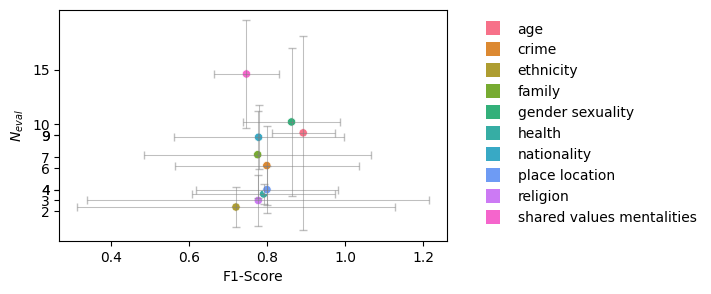

In [161]:
# using `pdat`, create a scatter plot of `f1-score`` against `support`

attributes = pdat_agg['attribute'].unique()
attributes_palette = sns.color_palette("husl", len(attributes))

plt.figure(figsize=(5, 3))


# add vertical error bars for stddev of f1-score
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        xerr=row["f1_std"],
        fmt='none',
        ecolor='gray',
        # palette=attributes_palette,
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )
# add horizontal error bars for stddev of support
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        yerr=row["support_std"],
        fmt='none',
        ecolor='gray',
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )


sns.scatterplot(
    data=pdat_agg,
    y="support",
    x="f1",
    hue="attribute",
    palette=attributes_palette,
    alpha=1,
    # s=100,
    legend=False
)

plt.yticks(pdat_agg.support.round(0))

# create custom legend handles for attributes
attributes = pdat_agg['attribute'].unique()
attributes_legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=attributes_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(attributes)
]
# show legend 
plt.legend(
    handles=attributes_legend_elements,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
)
plt.xlabel("F1-Score")
plt.ylabel("$N_{eval}$")

#### Error analysis

In [162]:
preds_df = pd.concat({
    fp.parts[-5:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['model'] = preds_df['model_name'].str.split('--', expand=True)[1]
preds_df['model_name'] = pd.Categorical(preds_df['model_name'], categories=models_names, ordered=True)
preds_df['strategy'] = pd.Categorical(preds_df['strategy'], categories=strategies, ordered=True)

preds_df = preds_df.sort_values(["method", "model_name", "strategy", "mention_id", "attribute", "fold"]).reset_index(drop=True)

In [163]:
preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [164]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [165]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [166]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for (a, l), subdf in error_rates_df.groupby(['attribute', 'label']):
    # print attribute name in bold
    print(f"\033[1m{a}\033[0m ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
    for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
        highlighted_text = highlight(row['text'], row['mention'])
        print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
    print()

noneconomic__age ~> false positives
  - 171101_201207-307739-1 (1.00):  While young people with higher and higher middle education are the only population group that has increased their active participation rate (TPEA) over the past decade, in apparent paradox, their open unemployment rate (TDA) shows that higher schooling is exposed to higher unemployment.
  - 171101_200306-303319-1 (0.92):  In 40% of the families of these young people, the characteristics of the reference group of their children are unknown, as well as the activities they regularly carry out.
  -  41953_201309-162347-1 (0.42):  Parents are primarily responsible for the education and upbringing of their children.
  -  41953_201709-170789-1 (0.35):  The AfD wants the family policy of the Federation and the states to be based on the image of the family of father, mother and children.
  -  11110_198809-390636-1 (0.34):  Give parents the right to become municipal daycare providers for their own child.

noneconomic__age ~>

<Axes: >

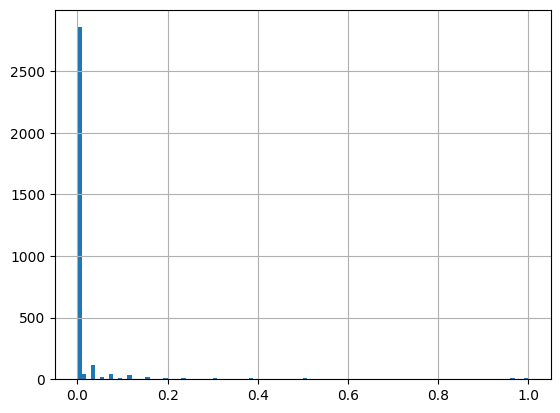

In [167]:
error_rates_df.error.hist(bins=100)

In [168]:
error_rates_df_review_noneconomic = error_rates_df.copy()

error_rate_threshold_economic = np.quantile(error_rates_df.error, 0.95)
print(error_rate_threshold_economic)

error_rates_df_review_noneconomic['label'] = error_rates_df_review_noneconomic['label'].astype(str)
idxs = error_rates_df_review_noneconomic.error > error_rate_threshold_economic
error_rates_df_review_noneconomic.loc[idxs, 'label'] = error_rates_df_review_noneconomic.loc[idxs, 'label'].astype(str) + '??'

0.1877637130801675


### Export high-error rate mentions for human review

In [169]:
error_rates_df_review_economic = error_rates_df_review_economic.pivot(index=['mention_id', 'text', 'mention', 'span'], columns='attribute', values='label').reset_index()
error_rates_df_review_economic.columns.name = None

error_rates_df_review_noneconomic = error_rates_df_review_noneconomic.pivot(index=['mention_id', 'text', 'mention', 'span'], columns='attribute', values='label').reset_index()
error_rates_df_review_noneconomic.columns.name = None

In [170]:
error_rates_df_review = error_rates_df_review_economic.merge(error_rates_df_review_noneconomic)
these = error_rates_df_review.iloc[:, 4:].apply(lambda row: row.apply(lambda v: '??' in v).any(), axis=1)
error_rates_df_review = error_rates_df_review[these]

len(error_rates_df_review)

186

In [174]:
base_path = Path("../../")
annotations_path = base_path / "data" / "annotations" / "group_mention_categorization"
dest = annotations_path / "attribute-misclassification-review"
dest.mkdir(parents=True, exist_ok=True)
fp = dest / "sample.csv"
error_rates_df_review.to_excel(fp, index=False)

### eval in mads  thaus' data

In [ ]:
import pandas as pd
from pathlib import Path
df = [
    {"id":"conservatives-1964-135-2","text":"special insurance provision has already been directed to widows with children.","label":[[57,77,"none",1]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-65-1","text":"competition and free choice are the customers' most effective safeguards.","label":[[36,46,"Other",3]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-189-1","text":"the consistent aim of conservative policy is to uphold the british way of life, centred upon the dignity and liberty of the individual.","label":[[120,134,"none",4],[124,134,"none",20],[120,134,"none",74],[120,134,"none",79]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-121-1","text":"the minimum school-leaving age will be raised to 16 for all who enter secondary school after the summer of 1967.","label":[[56,111,"Age/generation",6]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-68-2","text":"but the interests of those who work in industry must be fully safeguarded in the process.","label":[[21,47,"Economic class",7]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-143-2","text":"the level of pensions for retired members of the armed forces and other government servants will be adjusted as necessary.","label":[[26,91,"none",8]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-75-3","text":"our studies for this purpose now cover wales, scotland and most of england.","label":[[46,54,"Geography",9],[59,74,"Geography",42],[46,54,"Geography",52]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-76-1","text":"in central scotland and north-east england we are already carrying out programmes without precedent in conception and scale.","label":[[11,19,"Geography",9],[11,19,"Geography",52]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-202-1","text":"we are issuing, simultaneously with this manifesto, special statements recording our achievements and plans in scotland and in wales.","label":[[111,119,"Geography",9],[111,119,"Geography",52],[127,132,"Geography",152],[127,132,"Geography",155]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-77-4","text":"we are determined to check the drift to the south and to achieve a sound balance over the whole country.","label":[[81,103,"Geography",10],[40,49,"Geography",48]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-150-3","text":"as each authority completes this task, we shall go on to redevelop out-dated residential areas.","label":[[67,94,"Geography",11],[67,94,"Economic class",44]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-187-3","text":"whilst strictly safeguarding secluded areas, the commission will advise planning authorities on the designation of recreation areas\" where boating, climbing, gliding and similar activities will be welcome.","label":[[29,43,"Geography",12]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-152-2","text":"the 1964 housing act provides for systematic improvement in older areas, with powers of compulsion where landlords are not persuaded to co-operate by the better grant arrangements.","label":[[60,71,"Geography",14],[105,114,"Economic class",100]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-169-1","text":"the past thirteen years have seen improvements in the nation's health greater than in any comparable period.","label":[[50,62,"none",15],[50,62,"none",89]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-172-1","text":"in these plans for the nation's health, the scope for voluntary service will be emphasised, and we shall concentrate on the human approach which can make all the difference when a person is sick, handicapped or lonely.","label":[[19,31,"none",15],[19,31,"none",89],[178,186,"none",95]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-115-1","text":"local authority services are expanding in response to public need and demand, but in some instances and areas the cost is outpacing the capacity of householders to pay.","label":[[148,160,"Other",16]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-116-2","text":"in carrying out these and any other necessary reforms, we shall bear specially in mind those householders living on small fixed incomes.","label":[[93,105,"Other",16],[87,135,"Economic class",36],[87,135,"Other",168]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-171-3","text":"support for old people living at home will come from increasing numbers of health visitors, home nurses, home helps and social workers for those who can no longer manage on their own, there will be modern, specially designed accommodation.","label":[[92,103,"none",17],[139,182,"Health",21],[12,37,"Age/generation",117],[120,134,"none",131],[75,90,"none",136],[105,115,"none",175]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-114-1","text":"we shall continue to reform the tax system, both on companies and on individuals, to make it less complicated and fairer in its incidence.","label":[[69,80,"none",18],[52,61,"Economic class",40]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-202-3","text":"they also show how our programmes are designed to secure the even spread of prosperity throughout great britain.","label":[[87,111,"Geography",19]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-137-1","text":"our graduated pension scheme, started in 1961, embodied the principle that retirement pensions should be more closely related to individual earnings.","label":[[129,139,"none",20]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-190-2","text":"we safeguarded individual rights at tribunals and inquiries along the lines suggested by the franks report.","label":[[15,25,"none",20]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
    {"id":"conservatives-1964-170-1","text":"the conservative hospital plan will ensure that every man, woman and child in the country has access to the best treatment.","label":[[48,89,"Gender",25],[48,89,"none",54],[48,89,"Gender",92]],"metadata":{"party":51620,"date":"1964","doc_name":"conservatives-1964.md"}},
]
df = pd.DataFrame(df)
df = df.explode('label', ignore_index=True)
labels = df.label.apply(pd.Series)
metadata = df.metadata.apply(pd.Series)
df[metadata.columns] = metadata
del df["metadata"]
df[["start", "end", "attribute", "label_id"]] = labels
del df["label"]
df['mention'] = df.apply(lambda row: row['text'][row['start']:row['end']], axis=1)

In [ ]:
for a, subdf in df.groupby('attribute'):
    print(f"Attribute: {a}")
    for i, row in subdf.sample(min(5, len(subdf)), random_state=42).iterrows():
        print(f" - {row['mention']}")


Attribute: Age/generation
 - old people living at home
 - all who enter secondary school after the summer of 1967
Attribute: Economic class
 - out-dated residential areas
 - companies
 - landlords
 - those who work in industry
 - those householders living on small fixed incomes
Attribute: Gender
 - every man, woman and child in the country
 - every man, woman and child in the country
Attribute: Geography
 - over the whole country
 - out-dated residential areas
 - scotland
 - older areas
 - scotland
Attribute: Health
 - those who can no longer manage on their own
Attribute: Other
 - householders
 - those householders living on small fixed incomes
 - customers'
 - householders
Attribute: none
 - widows with children
 - retired members of the armed forces and other government servants
 - home nurses
 - the individual
 - the nation's
